In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
import statistics
from sklearn import metrics
df = pd.read_excel("SupplyChain_TimeSeriesData.xlsx") #input the file

Importing plotly failed. Interactive plots will not work.


In [2]:
## create copy of df and retain only units dealing with L amounts
retain_unit = ['ML','L', 'µL']
df_liquid = df[df.Unit.isin(retain_unit)].copy(deep=True)

orders = df_liquid[df_liquid['Confirmation Start Date'] < pd.Timestamp(2017,1,1)]['Order'].unique()
df_liquid = df_liquid[~df_liquid['Order'].isin(orders)]


In [3]:
#Create colummns for actual duration and scheduled duration
df_liquid['scheduled_duration_nowkend'] = df_liquid.apply(lambda row: pd.bdate_range( row['Schedule Start Date'], row['Schedule Finish Date']).shape[0] \
                                            if not pd.isna(row['Schedule Start Date']) and not pd.isna(row['Schedule Finish Date']) else np.nan, axis=1 )
df_liquid['actual_duration_nowkend'] = df_liquid.apply(lambda row: pd.bdate_range( row['Confirmation Start Date'], row['Usage Decision Date']).shape[0] \
                                         if not pd.isna(row['Confirmation Start Date']) and not pd.isna(row['Usage Decision Date']) else np.nan, axis=1 )

In [4]:
#Change the units to ML
df_liquid.loc[df_liquid["Unit"] == "µL", "Total order quantity"] /= 1000
df_liquid.loc[df_liquid["Unit"] == "L", "Total order quantity"] *= 1000
df_liquid["Unit"] = "ML"

In [5]:
#Put df in chronological order
df_liquid = df_liquid.sort_values("Confirmation Start Date", ascending = 1)
df_liquid = df_liquid.dropna(subset=['Confirmation Start Date', 'Usage Decision Date'])



In [6]:
# df_liquid['Duration Difference'] = (df_liquid['actual_duration_nowkend'] - df_liquid['scheduled_duration_nowkend'])
# three_sigma = statistics.stdev(df_liquid['Duration Difference'][df_liquid['Duration Difference'] >= 0]) * 3
# df_liquid = df_liquid[df_liquid['Duration Difference'] <= three_sigma]

unique_group = pd.unique(df["Group"])
unique_group.sort()
unique_group
newDataSet = pd.DataFrame()

for value in unique_group:
    group = df_liquid.loc[(df["Group"] == value)] #group == 106, 100001064, 100001522, 100001520
    group = group.loc[group["actual_duration_nowkend"] > 0]
   # group.set_index("Confirmation Start Date", inplace = True)
    group = group.sort_values("Confirmation Start Date")
    group["per"] = group['Confirmation Start Date'].dt.to_period("M")
    
    if len(group) > 1:
        three_sigma = statistics.stdev(group['actual_duration_nowkend']) * 3
        group = group[group['actual_duration_nowkend'] <= three_sigma]
    
    
        dates = pd.unique(group["per"])
        # empty is an empty dataframe that I am adding rows to at the end of the for-loop

        for month in dates:
            df_month = group.loc[group["per"] == month]

            #Looking at Outliers
            q1 = df_month.quantile(0.25)[0]
            q2 = df_month.quantile(0.50)[0]
            q3 = df_month.quantile(0.75)[0]

            IQR = q3 - q1
            lower = q1 - 1.5*IQR
            upper = q3 + 1.5*IQR

            temp = df_month[(df_month["actual_duration_nowkend"] < upper)]
            temp['ds'] = df_month.index
            newDataSet = newDataSet.append(temp)


In [7]:
#X: input features
#Y: target variable 

X = newDataSet[['Group', 'MaterialCategory', 'Material', 'Total order quantity', 'Confirmation Start Date',]]
Y = newDataSet['actual_duration_nowkend']

In [8]:
#Training Data for Prophet

pro_df = pd.DataFrame()
pro_df['ds'] = X['Confirmation Start Date']
pro_df['y'] = Y
pro_df.shape

(13902, 2)

In [9]:
#Prophet Model with multiple regressors

pro_df['Material'] = X['Material']
pro_df['Group'] = X['Group']
pro_df['MaterialCategory'] = X['MaterialCategory']
pro_df['Total order quantity'] = X['Total order quantity']

pro_df = pro_df.sort_values(by = 'ds')


In [10]:
train_df = pro_df[ : 11121]
test_df = pro_df[11121 : ]

In [11]:
r = Prophet(yearly_seasonality = True, daily_seasonality = True)
r.add_regressor('Material')
r.add_regressor('Group')
r.add_regressor('MaterialCategory')


r.fit(train_df)

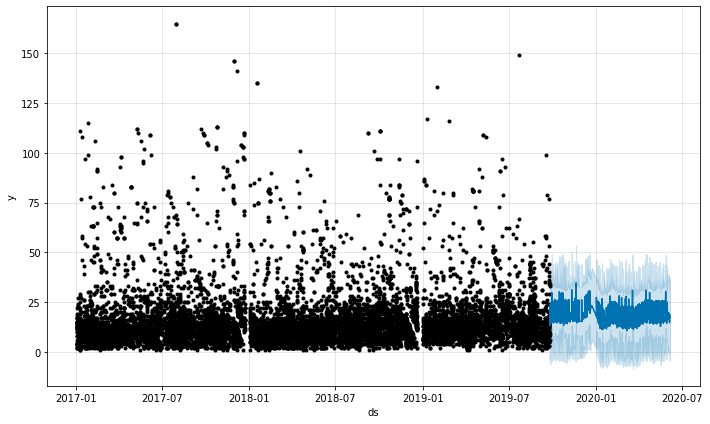

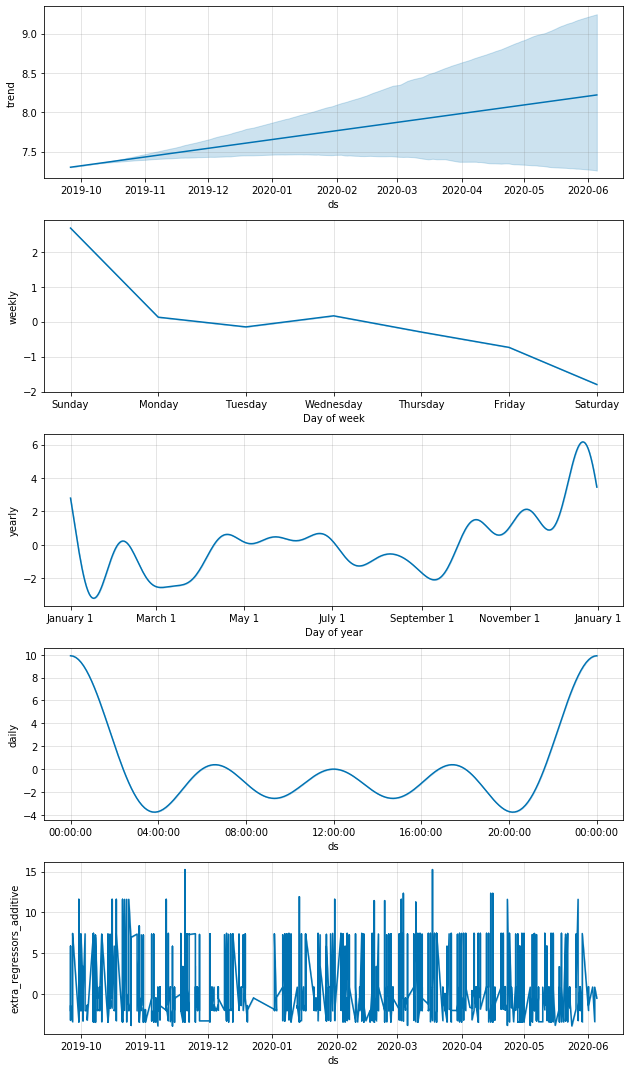

In [12]:
forecast_r = r.predict(test_df) 

fig3 = r.plot(forecast_r) 
fig4 = r.plot_components(forecast_r)

In [13]:
#Calculating Accuracy using MSE 

mse = metrics.mean_squared_error(test_df['y'], forecast_r['yhat'], squared=True)
print(mse)

129.60621973690323


In [14]:
test_df.head(10)

,ds,y,Material,Group,MaterialCategory,Total order quantity
28373,2019-09-26,10.0,100000620,129,1,67000.0
28374,2019-09-26,12.0,100000613,129,1,108000.0
28467,2019-09-26,17.0,100001039,131,1,1200.0
28507,2019-09-26,4.0,100002333,138,12,65.0
28216,2019-09-26,21.0,100000250,129,1,3000.0
28466,2019-09-26,29.0,100001468,131,1,1500.0
28460,2019-09-26,28.0,100000549,131,1,36700.0
28464,2019-09-26,20.0,100000636,130,1,2700000.0
28322,2019-09-26,14.0,100000340,134,1,183000.0
28457,2019-09-26,16.0,100000647,134,1,500000.0


In [15]:
from datetime import datetime

ds_str = "2020-07-08"
ds = datetime.strptime(ds_str, '%Y-%m-%d')

cols = {'ds': [ds], 'Material' : [100000551] , 'Group' : [143], 'MaterialCategory':[12]}

future = pd.DataFrame(cols)
